# 1. Loading Libraries

In [39]:
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, Input
import pickle  # Add this line to import the pickle module
import pandas as pd

# 2. Loading Dataset and generating visualizations

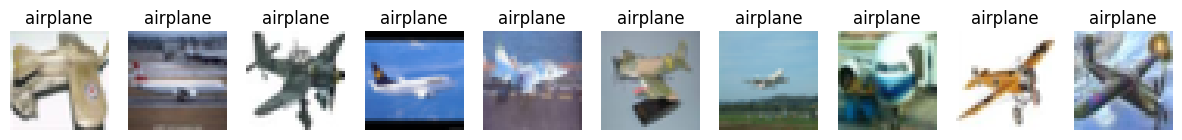

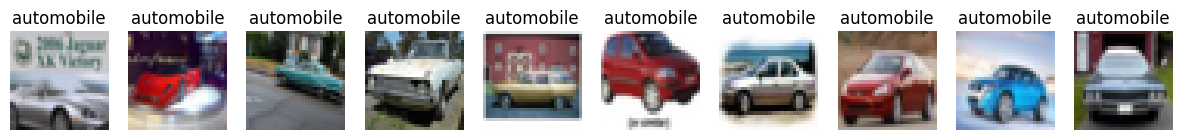

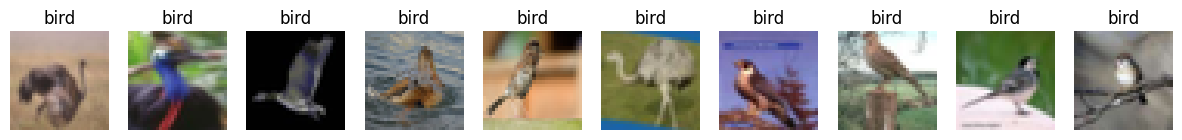

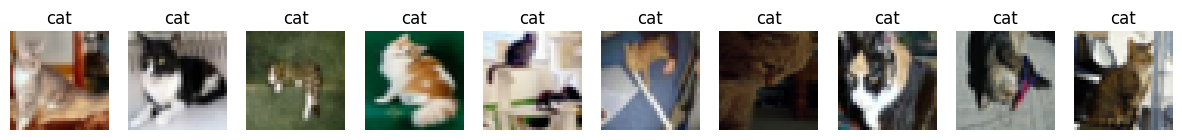

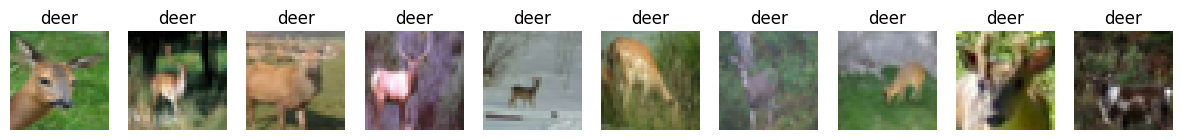

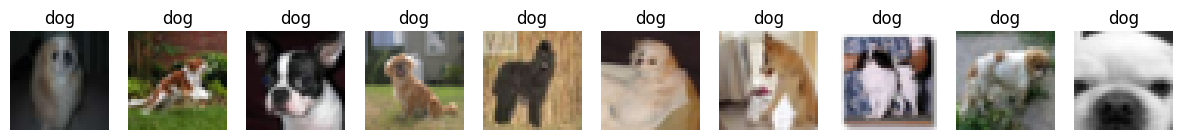

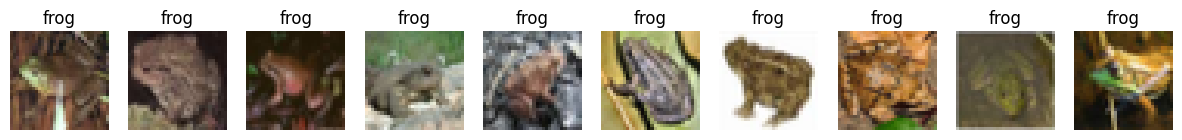

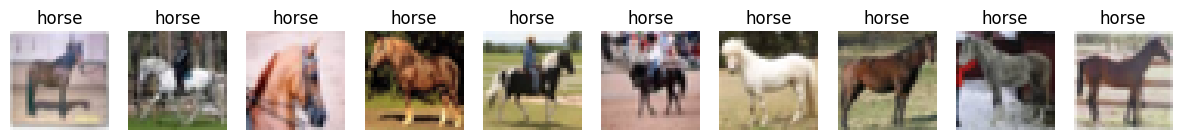

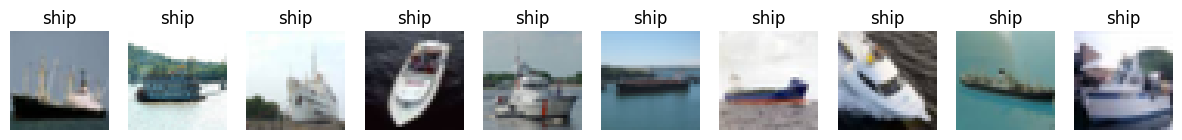

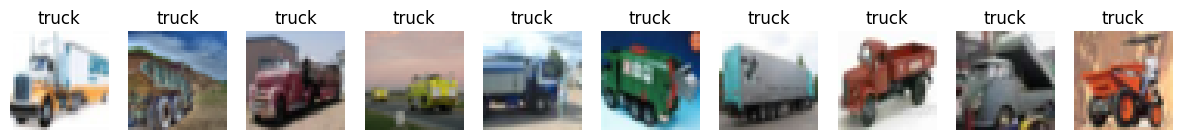

In [37]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
# Function to load all Cifar-10 batches
def load_all_cifar10_batches(directory):
    all_data = []
    for file_name in os.listdir(directory):
        if file_name.startswith("data_batch"):
            file_path = os.path.join(directory, file_name)
            with open(file_path, 'rb') as file:
                data_batch = pickle.load(file, encoding='bytes')
                all_data.append(data_batch)
    return all_data

# Function to display all 10 samples of the same class together in one row
def display_all_samples_by_class(all_data):
    # Create a dictionary to group images by class
    grouped_samples = {label: [] for label in range(10)}

    for data_batch in all_data:
        labels = np.array(data_batch[b'labels'])
        data_batch = np.array(data_batch[b'data'])
        data_batch = data_batch.reshape((len(data_batch), 3, 32, 32)).transpose(0, 2, 3, 1)

        for label in range(10):
            label_indices = np.where(labels == label)[0]
            random_indices = np.random.choice(label_indices, 2, replace=False)
            grouped_samples[label].extend(data_batch[random_indices])

    # Display all 10 samples of the same class together in one row
    for label, samples in grouped_samples.items():
        plt.figure(figsize=(15, 3))
        for i, image in enumerate(samples):
            plt.subplot(1, 10, i + 1)
            plt.imshow(image)
            plt.title(class_names[label])
            plt.axis('off')
        plt.show()

# Directory containing Cifar-10 batches
directory = '/kaggle/input/cifar10-python/cifar-10-batches-py'

# Load all batches of the dataset
all_cifar10_data = load_all_cifar10_batches(directory)

# Display all 10 samples of the same class together in one row
display_all_samples_by_class(all_cifar10_data)


# 2. Splitting data into train, validation, and test split

In [3]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training set shape: (40000, 32, 32, 3) (40000, 1)
Validation set shape: (10000, 32, 32, 3) (10000, 1)
Testing set shape: (10000, 32, 32, 3) (10000, 1)


In [24]:
import shutil

# Replace '/kaggle/working/' with the path of the directory you want to delete
directory_to_delete = '/kaggle/working/untitled_project'

# Delete the directory and its contents
shutil.rmtree(directory_to_delete)


In [10]:
!pip install keras-tuner  # Assuming you're using a Colab environment

# 3. Hyperparameter Tuning

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from kerastuner import HyperModel, RandomSearch

def build_model(hp):  # hp stands for HyperParameters
    inputs = layers.Input(shape=(32, 32, 3))

    # Hyperparameter: Number of filters in the first convolutional layer
    filters1 = hp.Int('filters1', min_value=16, max_value=128, step=32)
    x = layers.Conv2D(filters1, (3, 3))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters1, (3, 3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Hyperparameter: Number of filters in the second convolutional layer
    filters2 = hp.Int('filters2', min_value=32, max_value=256, step=64)
    x = layers.Conv2D(filters2, (3, 3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters2, (3, 3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Hyperparameter: Dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(10)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model (optimizer and loss function can also be hyperparameters)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

# Fix the error: Remove the executions argument
tuner = RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=15,
)

# Start hyperparameter tuning. Adjust epochs for tuning efficiency and desired accuracy.
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps)

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

# Evaluate the best model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Trial 4 Complete [00h 02m 08s]
val_accuracy: 0.5666999816894531

Best val_accuracy So Far: 0.6425999999046326
Total elapsed time: 00h 06m 36s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
16                |80                |filters1
96                |32                |filters2
0.4               |0.3               |dropout_rate

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.3719 - loss: 3.9633 - val_accuracy: 0.5181 - val_loss: 2.0485
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5616 - loss: 1.8927 - val_accuracy: 0.4512 - val_loss: 2.2227
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5898 - loss: 1.8193 - val_accuracy: 0.4438 - val_loss: 2.2482
Epoch 4/10
 581/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6052 - loss: 1.7883

KeyboardInterrupt: 

# 4. Display the best hyper-parameters

In [19]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps)

# Extract the best hyperparameters
best_filters1 = best_hps.get('filters1')
best_filters2 = best_hps.get('filters2')
best_dropout_rate = best_hps.get('dropout_rate')

print("Best Filters in the First Convolutional Layer:", best_filters1)
print("Best Filters in the Second Convolutional Layer:", best_filters2)
print("Best Dropout Rate:", best_dropout_rate)


Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7cf25cc5e950>
Best Filters in the First Convolutional Layer: 48
Best Filters in the Second Convolutional Layer: 224
Best Dropout Rate: 0.2


In [26]:
# Define the best hyperparameters
best_filters1 = 48
best_filters2 = 224
best_dropout_rate = 0.2


# 5. Data Augmentation to avoid overfitting

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_datagen.fit(X_train)
# Build the model using the best hyperparameters without regularization
def build_model():
    inputs = layers.Input(shape=(32, 32, 3))

    # First Convolutional Layer
    x = layers.Conv2D(best_filters1, (3, 3))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(best_filters1, (3, 3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second Convolutional Layer
    x = layers.Conv2D(best_filters2, (3, 3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(best_filters2, (3, 3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten layer
    x = layers.Flatten()(x)

    # Dropout layer
    x = layers.Dropout(best_dropout_rate)(x)

    # Fully connected layer
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Dropout layer
    x = layers.Dropout(best_dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(10)(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Build the model
model = build_model()

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32), epochs=25, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 30, 30, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 30, 30, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 28, 28, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 224)    │        96,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 12, 224)    │           896 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 12, 12, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 10, 10, 224)    │       451,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 10, 224)    │           896 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 10, 10, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 224)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       716,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,291,834 (4.93 MB)

 Trainable params: 1,290,490 (4.92 MB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.4106 - loss: 1.6438 - val_accuracy: 0.3862 - val_loss: 2.0226
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6082 - loss: 1.1070 - val_accuracy: 0.6012 - val_loss: 1.1647
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6716 - loss: 0.9415 - val_accuracy: 0.6040 - val_loss: 1.2969
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7002 - loss: 0.8627 - val_accuracy: 0.7311 - val_loss: 0.7656
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7254 - loss: 0.7932 - val_accuracy: 0.6791 - val_loss: 1.0568
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7381 - loss: 0.7497 - val_accuracy: 0.7711 - val_loss: 0.6612
Epoch 7/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7502 - loss: 0.7161 - val_accuracy: 0.7777 - val_loss: 0.6311
Epoch 8/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7630 - loss: 0.67

# 6. Plot validation loss and training loss

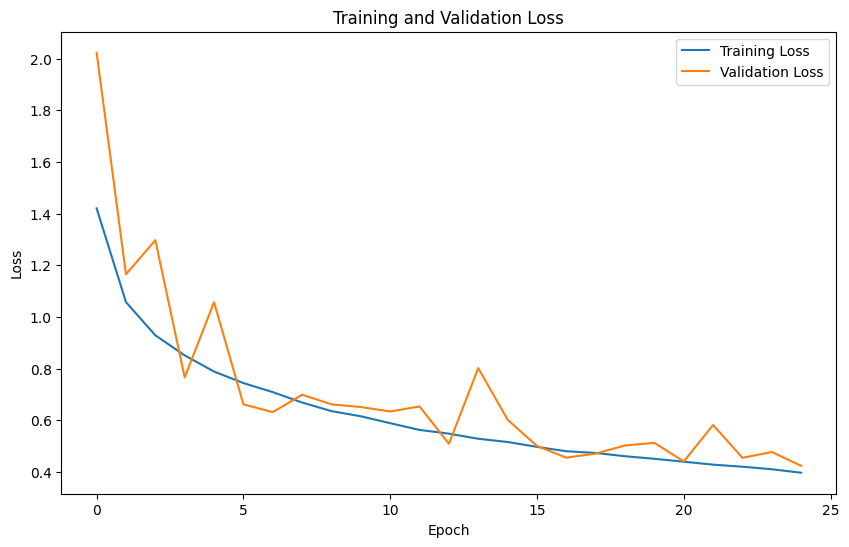

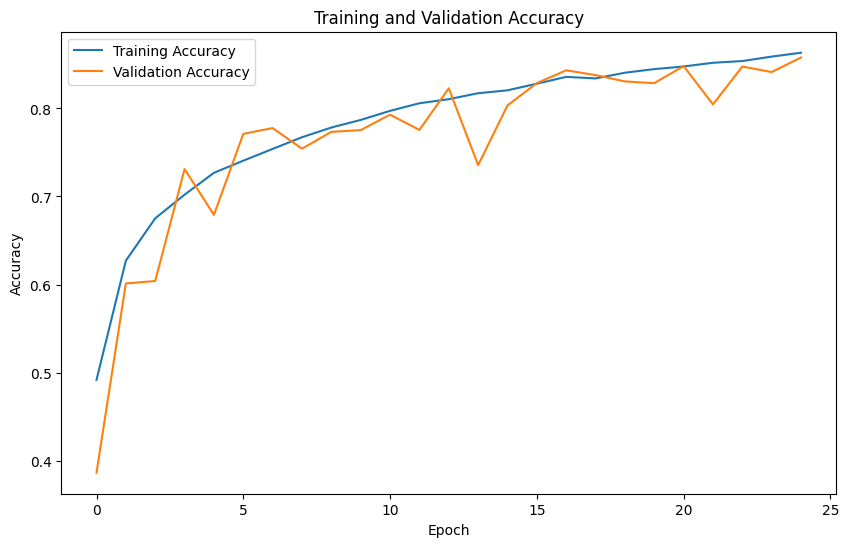

In [31]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from kerastuner import HyperModel, RandomSearch
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 7. Display Classification Report

In [40]:
import numpy as np 
from sklearn.metrics import classification_report

# Generate predictions for the test set
y_pred = model.predict(X_test)



# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Classification report
report = classification_report(y_test, y_pred_labels, target_names=class_names, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the classification report
print(report_df)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision  recall  f1-score     support
0              0.813665  0.9170  0.862247   1000.0000
1              0.897749  0.9570  0.926428   1000.0000
2              0.730442  0.8590  0.789522   1000.0000
3              0.765086  0.7100  0.736515   1000.0000
4              0.884916  0.7920  0.835884   1000.0000
5              0.896287  0.7000  0.786075   1000.0000
6              0.866218  0.9000  0.882786   1000.0000
7              0.884170  0.9160  0.899804   1000.0000
8              0.943677  0.8880  0.914992   1000.0000
9              0.894164  0.9040  0.899055   1000.0000
accuracy       0.854300  0.8543  0.854300      0.8543
macro avg      0.857637  0.8543  0.853331  10000.0000
weighted avg   0.857637  0.8543  0.853331  10000.0000


# 8. Display Top-5 Accuracy

In [41]:
# Calculate Top-5 Accuracy
def top5_accuracy(y_true, y_pred_proba):
    # Get the indices of the top 5 predicted probabilities for each sample
    top5_indices = np.argsort(y_pred_proba, axis=1)[:, -5:]
    
    # Check if the true label is within the top 5 predicted labels
    correct_top5 = np.array([y_true[i] in top5_indices[i] for i in range(len(y_true))])
    
    # Calculate the top-5 accuracy
    top5_accuracy = np.mean(correct_top5)
    
    return top5_accuracy

# Generate predictions for the test set
y_pred_proba = model.predict(X_test)

# Calculate Top-5 Accuracy
top5_acc = top5_accuracy(y_test, y_pred_proba)

print("Top-5 Accuracy:", top5_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Top-5 Accuracy: 0.9936


# 9. Confusion Matrix

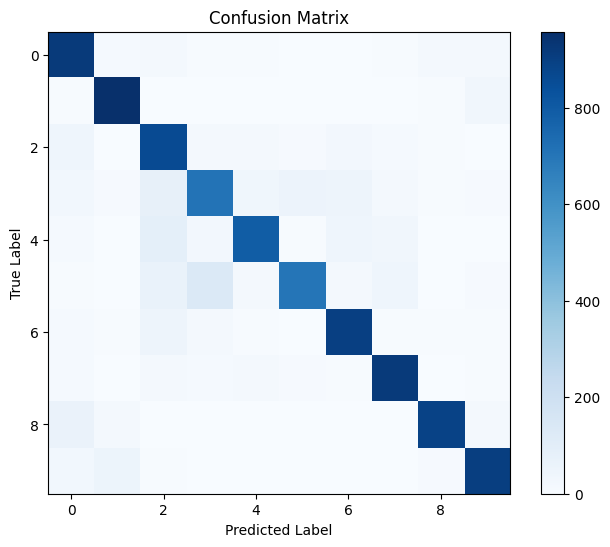

In [45]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# 10. One-vs-Rest ROC Curves and AUCs

In [47]:
# One-vs-Rest ROC Curves and AUCs
num_classes = 10  # Assuming 10 classes in CIFAR-10
y_pred = model.predict(X_test)
y_pred_proba = y_pred[:, 1:]  # Exclude the first column (background class)

ovr_auc_scores = {}
for class_index in range(1, num_classes):  # Skip background class (index 0)
  # OvR binary classification setup
  y_test_binary = np.zeros_like(y_test)
  y_test_binary[y_test == class_index] = 1

  # ROC curve and AUC calculation
  fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba[:, class_index - 1])
  auc_score = auc(fpr, tpr)

  # Store AUC score for this class
  ovr_auc_scores[class_index] = auc_score

print("OvR AUC Scores:", ovr_auc_scores)  # Dictionary of class vs. AUC score

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
OvR AUC Scores: {1: 0.9923872222222223, 2: 0.9665051111111111, 3: 0.9374443333333333, 4: 0.9777998888888889, 5: 0.9690544444444443, 6: 0.9870328888888888, 7: 0.989777, 8: 0.9917086666666667, 9: 0.9846218888888888}


# 11. Plotting the curves

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


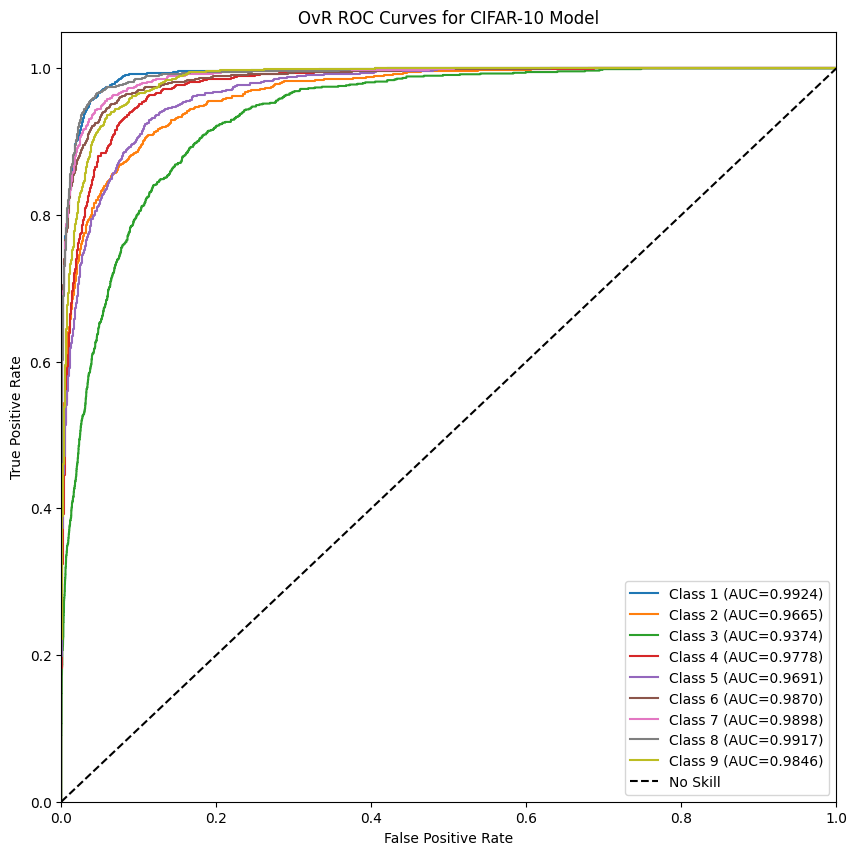

In [48]:
import matplotlib.pyplot as plt

# One-vs-Rest ROC Curves and AUCs
num_classes = 10  # Assuming 10 classes in CIFAR-10
y_pred = model.predict(X_test)
y_pred_proba = y_pred[:, 1:]  # Exclude the first column (background class)

plt.figure(figsize=(10, 10))  # Adjust figure size as needed

for class_index in range(1, num_classes):  # Skip background class (index 0)
  # OvR binary classification setup
  y_test_binary = np.zeros_like(y_test)
  y_test_binary[y_test == class_index] = 1

  # ROC curve and AUC calculation
  fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba[:, class_index - 1])
  auc_score = auc(fpr, tpr)

  # Plot ROC curve for this class
  plt.plot(fpr, tpr, label='Class %d (AUC=%0.4f)' % (class_index, auc_score))

# Plot additional elements
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OvR ROC Curves for CIFAR-10 Model')
plt.legend(loc='lower right')
plt.show()
